# Environment Setup
In case of no kernels / setup done

In [1]:
from IPython.display import clear_output
!pip install datasets transformers tqdm pandas numpy accelerate matplotlib qwen-vl-utils transformer-utils
clear_output()

# Initial Setup
Setting up RunPod-based cache storing, and importing libraries

In [2]:
import os
os.environ['HF_HOME'] = '/workspace/huggingface/'

In [3]:
import torch
import torch.nn.functional as F
from transformers import AutoProcessor, Qwen2_5_VLForConditionalGeneration
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from qwen_vl_utils import process_vision_info

/workspace/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Loading Mock VLMs
Please change the importing to your preferred VLMs loader~

In [4]:
MODEL_ID = "Qwen/Qwen2.5-VL-7B-Instruct"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DTYPE = torch.bfloat16

In [5]:
model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    MODEL_ID,
    dtype=DTYPE,
    device_map="auto",
).eval()
processor = AutoProcessor.from_pretrained(MODEL_ID, trust_remote_code=True, use_fast=True)

Fetching 1 files: 100%|██████████| 1/1 [00:00<00:00, 2331.46it/s]


# Prepping inputs

In [6]:
prompt = "What is this image?"
image_path = "./assets/img1.png"
image = Image.open(image_path).convert("RGB")

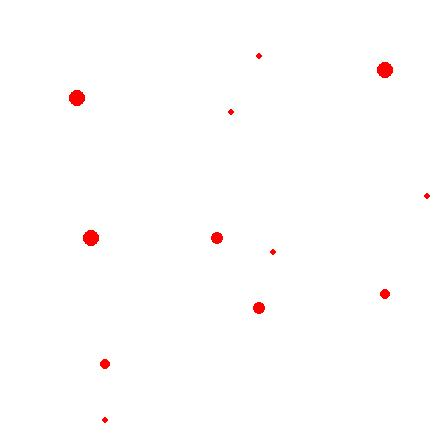

In [7]:
image.show()

In [8]:
messages = [
    {"role": "system", "content": ""},
    {"role": "user", "content": [
        {"type": "image", "image": image},
        {"type": "text", "text": prompt}
    ]}
]

image_inputs, _ = process_vision_info(messages)

In [ ]:
prompt = "What is this image?"
image_path = "./assets/img1.png"
image = Image.open(image_path).convert("RGB")

messages = [
    {"role": "system", "content": ""},
    {"role": "user", "content": [
        {"type": "image", "image": image},
        {"type": "text", "text": prompt}
    ]}
]

image_inputs, _ = process_vision_info(messages)

input_text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=False)
input_text = input_text.replace("system\n", "")

inputs = processor(
    text=[input_text],
    images=image_inputs,
    return_tensors="pt",
    padding=True
).to(model.device)

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Running logit lens analysis...
Generated text: 
user
What is this image?
 addCriterion
```json
{
  "image": {
    "type":

Generated 15 tokens
Actual tokens: [' addCriterion', '\n', '```', 'json', '\n', '{\n', ' ', ' "', 'image', '":', ' {\n', '   ', ' "', 'type', '":']
Matrix shape: 29 layers x 15 tokens


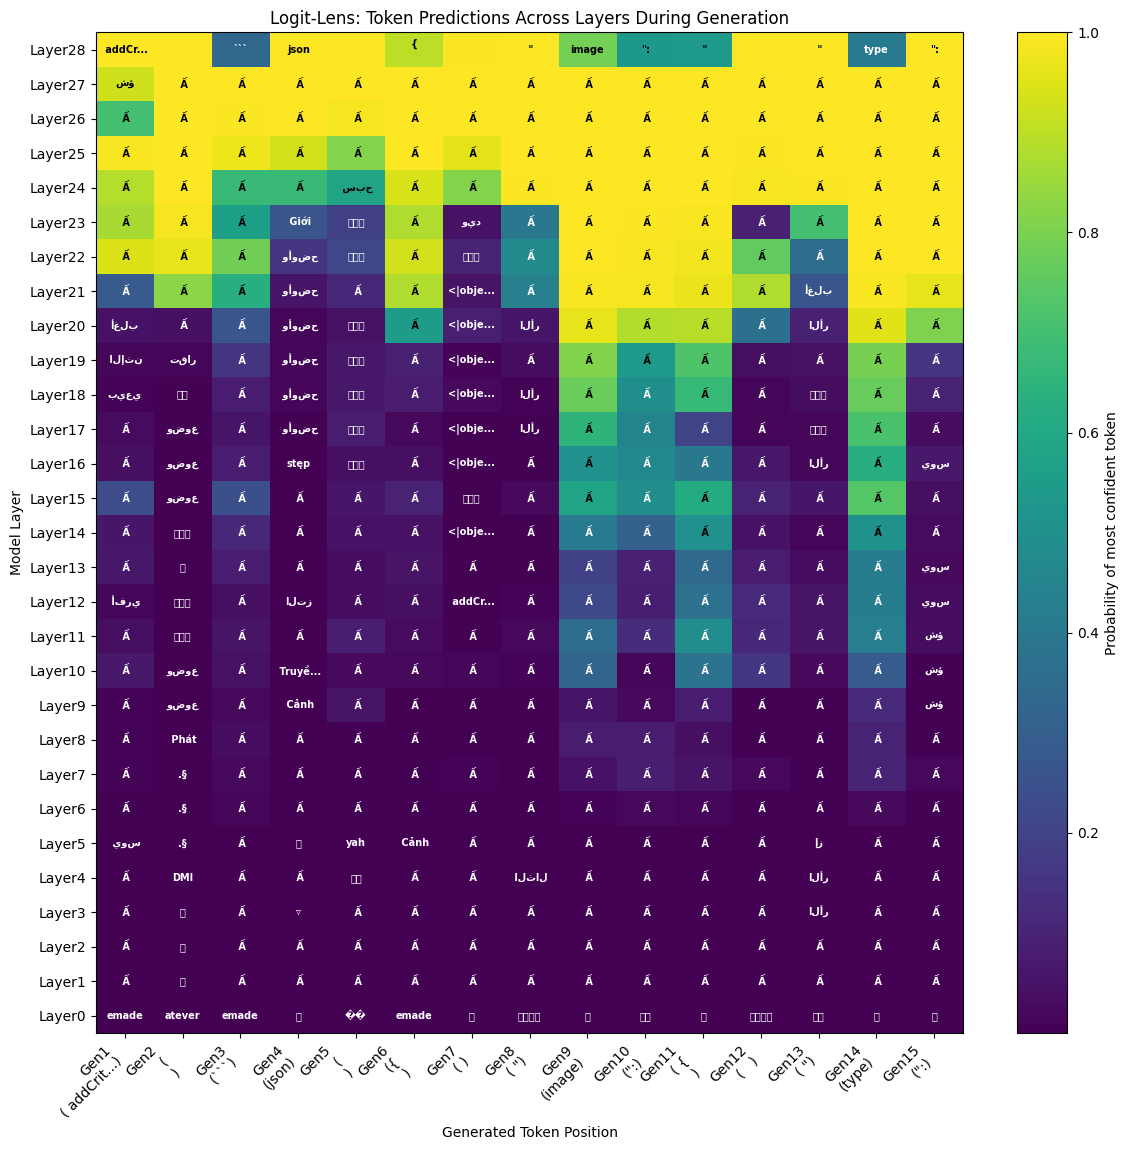

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from warnings import filterwarnings
filterwarnings('ignore')

def logit_lens_generated_tokens_all(model, processor, outputs):
    """
    Extracts the most confident token per layer for each newly generated token.
    
    Args:
        model: HuggingFace transformer model with lm_head
        processor: tokenizer + processor
        outputs: output of model.generate(return_dict_in_generate=True, output_hidden_states=True)
    Returns:
        tokens_matrix: 2D list (rows=layers, columns=generated tokens)
        probs_matrix: 2D list of probabilities per layer per generated token
    """
    hidden_states_per_step = outputs.hidden_states
    num_generated_tokens = len(hidden_states_per_step)
    
    if num_generated_tokens == 0:
        return [], []
    
    num_layers = len(hidden_states_per_step[0])
    
    tokens_matrix = [[] for _ in range(num_layers)]  # layers x generated_tokens
    probs_matrix = [[] for _ in range(num_layers)]   # layers x generated_tokens
    
    # Get the final layer norm if it exists
    final_norm = getattr(model.model, "norm", None)
    
    # Process each generation step
    for step_idx in range(num_generated_tokens):
        step_hidden_states = hidden_states_per_step[step_idx]
        
        # Process each layer for this generation step
        for layer_idx in range(num_layers):
            layer_hidden_state = step_hidden_states[layer_idx]
            
            # Handle tuple output (some models return tuples)
            if isinstance(layer_hidden_state, tuple):
                layer_hidden_state = layer_hidden_state[0]
            
            # Get the last token's hidden state (the newly generated token)
            vec = layer_hidden_state[0, -1, :]  # [batch_size=1, seq_len, hidden_dim]
            
            # Apply final normalization if it exists (usually only for the last layer)
            if final_norm is not None and layer_idx == num_layers - 1:
                vec = final_norm(vec)
            
            # Get logits and probabilities
            logits = model.lm_head(vec)
            probs = torch.softmax(logits, dim=-1)
            top_idx = torch.argmax(probs)
            
            # Store the most confident token and its probability
            token_str = processor.tokenizer.decode([top_idx.item()])
            tokens_matrix[layer_idx].append(token_str)
            probs_matrix[layer_idx].append(probs[top_idx].item())
    
    return tokens_matrix, probs_matrix

def plot_generated_logit_lens(tokens_matrix, probs_matrix, actual_generated_tokens=None):
    """
    Plot the logit lens heatmap for generated tokens.
    
    Args:
        tokens_matrix: 2D list (layers x generated_tokens)
        probs_matrix: 2D list of probabilities
        actual_generated_tokens: list of actual generated tokens for comparison
    """
    if not tokens_matrix or not tokens_matrix[0]:
        print("No tokens to plot!")
        return
    
    num_layers = len(tokens_matrix)
    num_generated_tokens = len(tokens_matrix[0])
    
    prob_array = np.array(probs_matrix)
    
    plt.figure(figsize=(max(num_generated_tokens*0.8, 8), max(num_layers*0.4, 6)))
    im = plt.imshow(prob_array, cmap="viridis", aspect='auto', origin='lower')
    cbar = plt.colorbar(im)
    cbar.set_label("Probability of most confident token")
    
    # X-axis: Generated token positions
    x_labels = [f"Gen{i+1}" for i in range(num_generated_tokens)]
    if actual_generated_tokens is not None:
        # Truncate long tokens for display
        actual_tokens_display = [tok[:8] + "..." if len(tok) > 8 else tok 
                               for tok in actual_generated_tokens[:num_generated_tokens]]
        x_labels = [f"Gen{i+1}\n({tok})" for i, tok in enumerate(actual_tokens_display)]
    
    plt.xticks(ticks=np.arange(num_generated_tokens), labels=x_labels, rotation=45, ha='right')
    plt.yticks(ticks=np.arange(num_layers), labels=[f"Layer{i}" for i in range(num_layers)])
    
    plt.xlabel("Generated Token Position")
    plt.ylabel("Model Layer")
    plt.title("Logit-Lens: Token Predictions Across Layers During Generation")
    
    # Add text annotations showing the predicted tokens
    for layer_idx in range(num_layers):
        for token_idx in range(num_generated_tokens):
            token_text = tokens_matrix[layer_idx][token_idx]
            # Truncate very long tokens for display
            display_text = token_text[:6] + "..." if len(token_text) > 6 else token_text
            
            plt.text(token_idx, layer_idx, display_text, 
                    ha='center', va='center', fontsize=7,
                    color='white' if prob_array[layer_idx, token_idx] < 0.5 else 'black',
                    weight='bold')
    
    plt.tight_layout()
    plt.show()

def get_actual_generated_tokens(processor, outputs, input_length):
    """
    Extract the actual generated tokens for comparison.
    """
    generated_sequence = outputs.sequences[0]  # First (and only) sequence
    generated_tokens = generated_sequence[input_length:]  # Remove input tokens
    return [processor.tokenizer.decode([token]) for token in generated_tokens]

# Run the logit lens analysis
print("Running logit lens analysis...")

with torch.no_grad():
    input_length = inputs['input_ids'].shape[1]
    
    outputs = model.generate(
        **inputs,
        max_new_tokens=15,
        output_hidden_states=True,
        return_dict_in_generate=True,
        do_sample=False,
        pad_token_id=processor.tokenizer.eos_token_id
    )

# Extract the generated text
generated_text = processor.tokenizer.decode(
    outputs.sequences[0],
    skip_special_tokens=True
)
print(f"Generated text: {generated_text}")

# Extract logit lens data
tokens_matrix, probs_matrix = logit_lens_generated_tokens_all(model, processor, outputs)
actual_tokens = get_actual_generated_tokens(processor, outputs, input_length)

print(f"\nGenerated {len(actual_tokens)} tokens")
print(f"Actual tokens: {actual_tokens}")
print(f"Matrix shape: {len(tokens_matrix)} layers x {len(tokens_matrix[0]) if tokens_matrix else 0} tokens")

# Plot the logit lens visualization
plot_generated_logit_lens(tokens_matrix, probs_matrix, actual_tokens)

